### Singeltask 

In [27]:
import os 
import pandas as pd

ITERATIONS = 5
columns=["dataset","best_model_train_acc", "accuracy", "precision", "recall", "duration"]
stl_results_fcn = pd.DataFrame(columns=columns)
stl_results_res = pd.DataFrame(columns=columns)


for idx, dataset in enumerate(['GunPoint','Coffee','Beef','ECG200']):#enumerate(os.listdir('./archives/ucr')):

    bac = 0; acc=0; precision=0; recall=0; duration=0

    for itr in range(ITERATIONS): 
        fcn_model = pd.read_csv(f'./results/ucr/{dataset}/experiment_1/fcn/fcn_{itr}/original/df_best_model.csv')
        fcn_metrics = pd.read_csv(f'./results/ucr/{dataset}/experiment_1/fcn/fcn_{itr}/original/task1_df_metrics.csv')
        res_model = pd.read_csv(f'./results/ucr/{dataset}/experiment_1/resnet/resnet_{itr}/original/df_best_model.csv')
        res_metrics = pd.read_csv(f'./results/ucr/{dataset}/experiment_1/resnet/resnet_{itr}/original/task1_df_metrics.csv')

        

        fcn_vals = [fcn_model["best_model_train_acc"].values[0], 
                                    fcn_metrics["accuracy"].values[0], fcn_metrics["precision"].values[0],
                                    fcn_metrics["recall"].values[0], fcn_metrics["duration"].values[0]] 
        res_vals = [res_model["best_model_train_acc"].values[0], 
                                    res_metrics["accuracy"].values[0], res_metrics["precision"].values[0],
                                    res_metrics["recall"].values[0], res_metrics["duration"].values[0]] 
        #Read STL results for FCN classifier
        if itr == 0:
            stl_results_fcn.loc[idx] = [dataset] + fcn_vals
            stl_results_res.loc[idx] = [dataset] + res_vals
        else:
            stl_results_fcn.loc[idx, columns[1:]] += fcn_vals
            stl_results_res.loc[idx, columns[1:]] += res_vals

    stl_results_fcn.loc[idx, columns[1:]] /= ITERATIONS
    stl_results_res.loc[idx, columns[1:]] /= ITERATIONS

In [35]:
stl_results_fcn

,dataset,best_model_train_acc,accuracy,precision,recall,duration
0,GunPoint,1.0,0.994667,0.995000,0.994595,58.190942
1,Coffee,1.0,1.000000,1.000000,1.000000,52.494297
2,Beef,0.9,0.513333,0.543762,0.513333,46.221029
3,ECG200,1.0,0.892000,0.886973,0.876736,52.483538


In [36]:
stl_results_res

,dataset,best_model_train_acc,accuracy,precision,recall,duration
0,GunPoint,1.0,0.990667,0.990976,0.990541,118.796559
1,Coffee,1.0,1.000000,1.000000,1.000000,119.318874
2,Beef,1.0,0.726667,0.769762,0.726667,95.570736
3,ECG200,1.0,0.886000,0.886780,0.863542,103.154424


### Test Similarity of Attribution methods

- raw unscaled attribution vectors
- pearson 

In [37]:
import numpy as np
from utils.utils import read_dataset


archive = 'ucr'
dataset_name = 'GunPoint'
data_p = 'G:/Meine Ablage/master thesis/code/xai-tsc'

train_val = []
test_val  = []

for idx, dataset in enumerate(os.listdir('./archives/ucr')):
    ylen = 1
    data = read_dataset(data_p, archive, dataset, 'original', ylen)[dataset]
    ylen = len(data[0][0])
    try:
        _,cy,_,cy1 = read_dataset(data_p, archive, dataset, 'fcn_cam_raw', ylen)[dataset]
        _,igy,_,igy1 = read_dataset(data_p, archive, dataset, 'fcn_ig_raw', ylen)[dataset]
        train_val.append([dataset,np.mean(np.corrcoef(cy, igy, rowvar=True)), np.mean(np.square(cy- igy))])
        test_val.append([dataset,np.mean(np.corrcoef(cy1,igy1,rowvar=True)),  np.mean(np.square(cy1- igy1))])
    except Exception as e: 
        #print(dataset,"error", e)
        pass

    
pd.DataFrame(train_val,columns=["dataset", "correlation","mse"])
pd.DataFrame(test_val,columns=["dataset", "correlation", "mse"])


,dataset,correlation,mse
0,GunPoint,0.033619,161.954705
1,Coffee,0.149870,248.644808
2,Beef,0.038142,86.204029
3,ECG200,0.181066,206.729274


### Calcualte Custom Metrics for Attribution Prediction Task 


In [42]:
import tensorflow_addons as tfa
from utils.explanations import integrated_gradients
from keras.utils import CustomObjectScope
import tensorflow.keras as keras
import tensorflow as tf
import os
from utils.explanations import minmax_norm
from utils.explanations import calculate_ig_attributions
from sklearn.metrics import mean_absolute_error, mean_squared_error
from utils.utils import read_dataset
from sklearn.preprocessing import normalize



# Load model to calculate custom metrics 
def load_model(root_dir, archive_name, dataset_name, classifier, data_source): 
    with CustomObjectScope({'InstanceNormalization':tfa.layers.InstanceNormalization()}):
        model_path = f'{root_dir}/results/{archive_name}/{dataset_name}/' \
                                                + f'{classifier.split("_")[0]}/{classifier}/{data_source}/' \
                                                + f'best_model.hdf5'
        model =keras.models.load_model(model_path ,compile=False)
        return model
    

def norm(values): 
    if not type(values) == np.ndarray:
        return normalize(values.numpy().reshape(1,-1))[0]
    else: 
        return normalize(values.reshape(1,-1))[0]
    
#define shared trunk
network = 'fcn' 
    
#store custom metrics for model
models_train  = dict()
models_test   = dict()
# Loop over data

itr=0
for idx, dataset in enumerate(['GunPoint','Coffee','Beef','ECG200']):#enumerate(os.listdir('./archives/ucr')):
    print(dataset)
    ylen = 1
    #Just for now:

    data = read_dataset(data_p, archive, dataset, 'original', ylen)[dataset]
    #assertion,each ts has same length
    ylen = len(data[0][0])

    for model in ['fcn_mt_ae','fcn_mt_conv', 'fcn_mt_linear','resnet_mt_ae','resnet_mt_conv']: #'fcn_mt_linear']: #['fcn_mt_ae','fcn_mt_conv', 'fcn_mt_linear']: 
        model_type = model.split('_')[0] 
        print(model)
        try: 


            #Load initial values after STL training
            #cam_data_stl = read_dataset(data_p, archive, dataset, 'fcn_cam_raw', ylen)[dataset]
            ig_data_stl  = read_dataset(data_p, archive, dataset, f'{model_type}_ig_raw', ylen)[dataset]
            #Load required models
            #cam_link = f'./results/ucr/{dataset}/fcn/fcn_mt_ae_0.0/fcn_cam_raw/best_model.hdf5'
            #ucr\GunPoint\experiment_1\fcn\fcn_mt_ae_0\fcn_ig_raw
        
            ig_link  = f'./results/ucr/{dataset}/experiment_1/{model_type}/{model}_{itr}/{model_type}_ig_raw/best_model.hdf5'
            #f'./results/ucr/{dataset}/experiment_1/fcn/fcn_{itr}/original/
            #cam_model =keras.models.load_model(cam_link ,compile=False)
            ig_model = keras.models.load_model(ig_link ,compile=False)

            #Calculate new  attributions
            ig_attributions = calculate_ig_attributions(data_p, archive, f"{model}_0", dataset, f"{model_type}_ig_raw", task=2)
             # train and test data
            # 1,3 are the labels:  
            for t in [1,3]:
                
                tc = t 
                #Pearson and mse [p,m]
                pm1 = 0; pm2 = 0; mm1 = 0; mm2 = 0
                #predict values for all timeseries 
                print("pred", t, data[t-1].shape)

                pred = ig_model.predict(data[t-1])
                #run loop
                for ts in range(len(data[t])):                
                    #small workaround
                    #structure of attributions 0 --> train 1 --> test set
                    pm1 += np.corrcoef(norm(pred[1][ts].flatten()),norm(ig_data_stl[t][ts]))[0,1]

                    pm2 += np.corrcoef(norm(pred[1][ts].flatten()),norm(ig_attributions[0 if t == 1 else 1][ts][2]))[0,1]
                    mm1 += mean_squared_error(norm(pred[1][ts].flatten()),norm(ig_data_stl[t][ts]))
                    mm2 += mean_squared_error(norm(pred[1][ts].flatten()),norm(ig_attributions[0 if t == 1 else 1][ts][2]))
                #Init for model 
                l = len(data[t])
                if t == 1: 
                    #f'{dataset}_{model.split("_")[-1]}'
                    models_train[f'{dataset}_{model.split("_")[-1]}'] = {"model" : model, "pm1":pm1/l,"pm2": pm2/l,"mm1":mm1/l, "mm2": mm2/l}
                else: 
                    models_test[f'{dataset}_{model.split("_")[-1]}'] =  {"model" : model , "pm1":pm1/l, "pm2": 
                                                                         pm2/l, "mm1":mm1/l,  "mm2": mm2/l}
                
        except Exception as e: 
            print(dataset,"error", e)
            pass


 #./results/ucr/GunPoint/experiment_1/resnet/resnet_mt_conv_0/resnet_ig_raw/last_model.hdf5
    



GunPoint
fcn_mt_ae
5/5 [==============================] - 0s 29ms/step
pred 1 (50, 150)
2/2 [==============================] - 0s 17ms/step
pred 3 (150, 150)
5/5 [==============================] - 0s 25ms/step
fcn_mt_conv
5/5 [==============================] - 0s 39ms/step
pred 1 (50, 150)
2/2 [==============================] - 0s 14ms/step
pred 3 (150, 150)
5/5 [==============================] - 0s 20ms/step
fcn_mt_linear
5/5 [==============================] - 0s 23ms/step
pred 1 (50, 150)
2/2 [==============================] - 0s 8ms/step
pred 3 (150, 150)
5/5 [==============================] - 0s 10ms/step
resnet_mt_ae
5/5 [==============================] - 0s 38ms/step
pred 1 (50, 150)
2/2 [==============================] - 2s 39ms/step
pred 3 (150, 150)
5/5 [==============================] - 0s 53ms/step
resnet_mt_conv
5/5 [==============================] - 0s 33ms/step
pred 1 (50, 150)
2/2 [==============================] - 1s 20ms/step
pred 3 (150, 150)
5/5 [====================

In [ ]:
#pd.DataFrame(models_train).T
#last model 
pd.DataFrame(models_test).T


,model,pm1,pm2,mm1,mm2
GunPoint_ae,resnet_mt_ae,0.765583,0.031046,0.003081,0.013329
GunPoint_conv,resnet_mt_conv,0.689036,-0.035608,0.004058,0.015573
GunPoint_linear,fcn_mt_linear,0.054091,0.030298,0.012332,0.012141
Coffee_ae,resnet_mt_ae,0.33802,0.102503,0.004607,0.006119
Coffee_conv,resnet_mt_conv,0.309833,0.172892,0.004804,0.006197
Coffee_linear,fcn_mt_linear,0.102575,-0.026235,0.006143,0.007823
Beef_ae,resnet_mt_ae,0.278857,-0.009458,0.003048,0.004278
Beef_conv,resnet_mt_conv,0.197463,0.023073,0.003417,0.004145
Beef_linear,fcn_mt_linear,0.36994,-0.066514,0.002763,0.004141
ECG200_ae,resnet_mt_ae,0.373016,0.161648,0.012718,0.016791


In [43]:
#best model
pd.DataFrame(models_test).T


,model,pm1,pm2,mm1,mm2
GunPoint_ae,resnet_mt_ae,0.773677,0.027958,0.003008,0.013225
GunPoint_conv,resnet_mt_conv,0.697267,-0.062936,0.003967,0.015363
GunPoint_linear,fcn_mt_linear,0.033044,0.149257,0.012514,0.01149
Coffee_ae,resnet_mt_ae,0.339046,0.050149,0.004602,0.006477
Coffee_conv,resnet_mt_conv,0.310106,0.127859,0.004802,0.006474
Coffee_linear,fcn_mt_linear,0.102575,-0.026235,0.006143,0.007823
Beef_ae,resnet_mt_ae,0.277045,0.012622,0.003058,0.004184
Beef_conv,resnet_mt_conv,0.191063,0.00227,0.003426,0.004237
Beef_linear,fcn_mt_linear,0.35534,-0.073053,0.002824,0.004196
ECG200_ae,resnet_mt_ae,0.355894,0.14771,0.013204,0.017276


: 

In [ ]:
#print(pred[1])
for ts in range(len(data[t])): 
    #print(pred[1][ts].flatten().shape,ig_attributions[ts][2].shape)

#### Visualization of the Experiment


In [ ]:
from scipy.interpolate import interp1d
def prepare_visualize_attribution(ts,attribution):
    max_length = 2000    
    #prepare values
    minimum = np.min(attribution)
    cas = attribution - minimum
    cas = cas / max(cas)
    cas = cas * 100
    xv= np.linspace(0, len(ts) - 1, max_length, endpoint=True)
    f = interp1d(range(len(ts)),ts)
    yv = f(xv)
    f = interp1d(range(len(ts)),cas)
    cas = f(xv).astype(int)
    return xv,yv,cas

4/4 [==============================] - 0s 23ms/step
(96,) (96,)


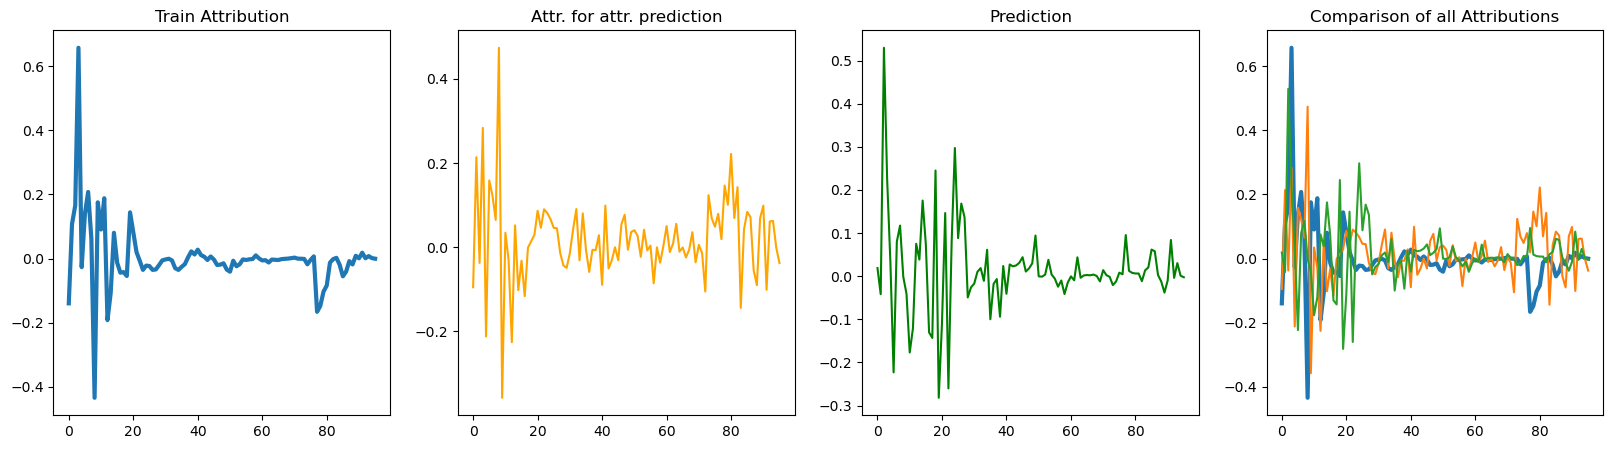

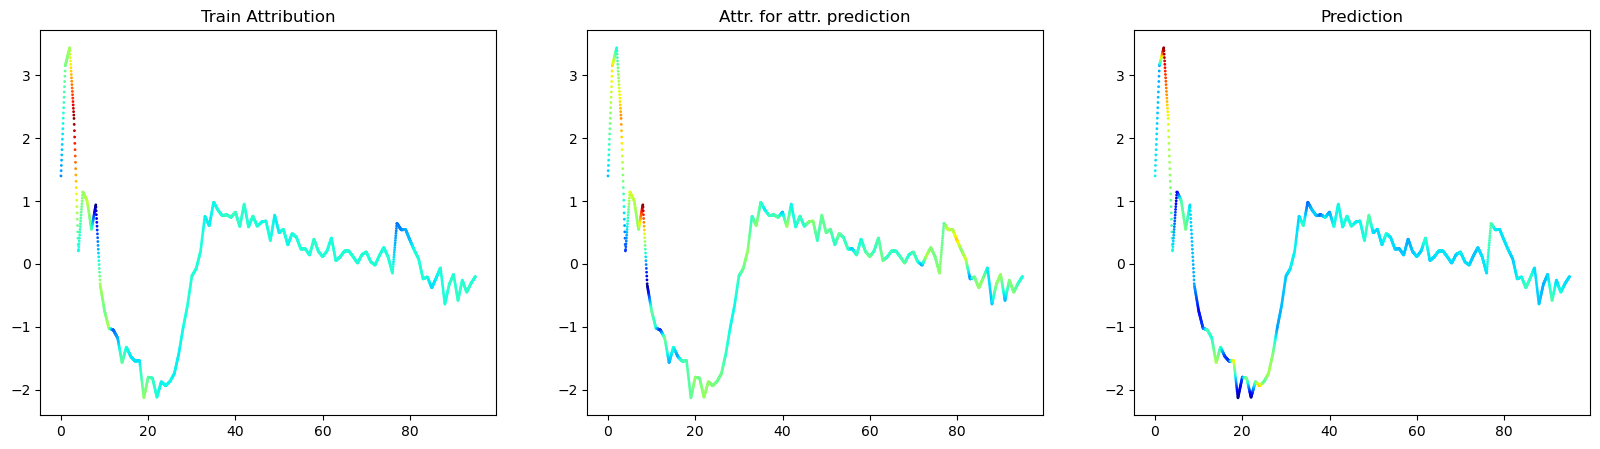

4/4 [==============================] - 0s 12ms/step
(96,) (96,)


<Figure size 640x480 with 0 Axes>

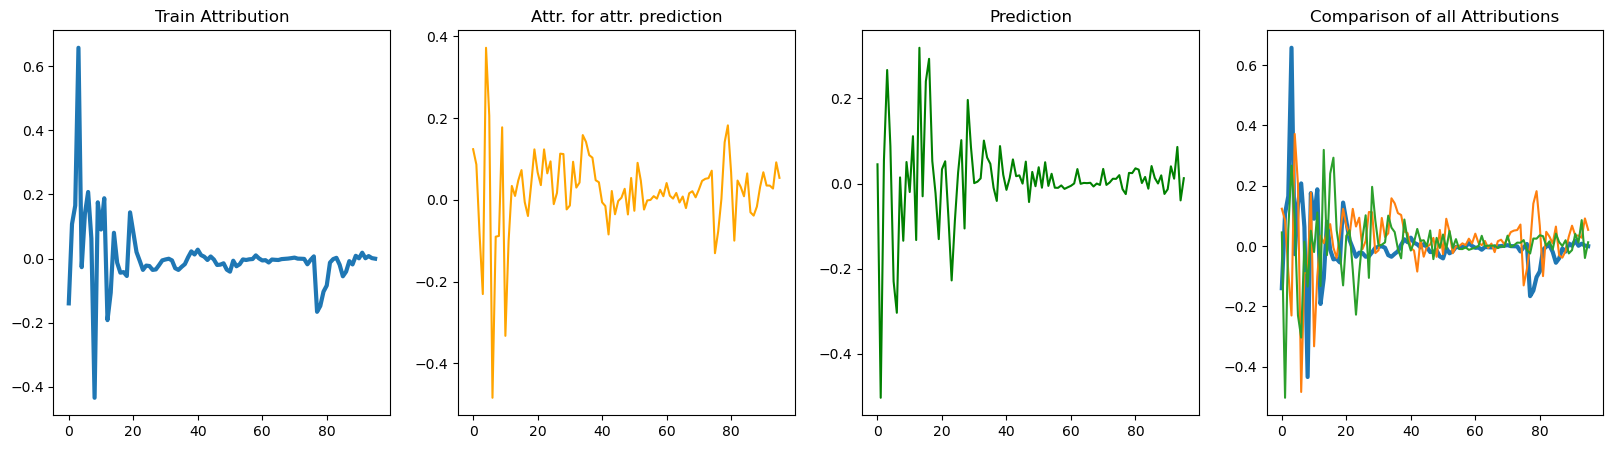

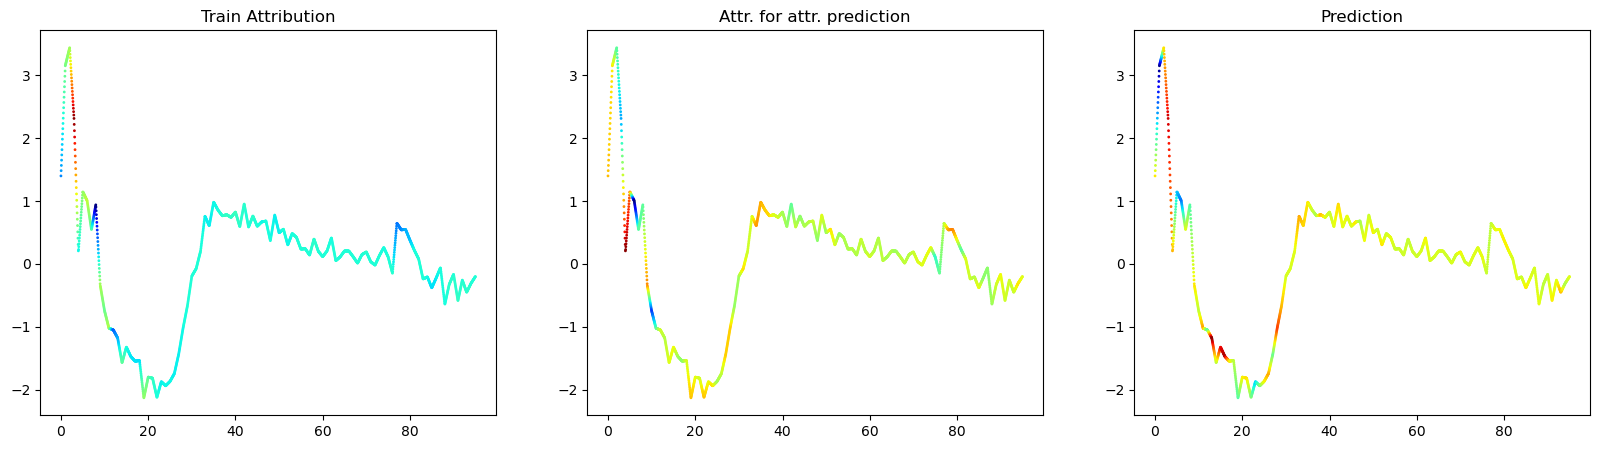

<Figure size 640x480 with 0 Axes>

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt 


def visualize_experiment_1(dataset,model, ts, train):

    for model in ['resnet_mt_ae','resnet_mt_conv']: #['fcn_mt_ae','fcn_mt_conv', 'fcn_mt_linear']: 
        model_type = model.split('_')[0] 
        ylen = 1 
        idx = 0 if  train else 2
        data = read_dataset(data_p, archive, dataset, 'original', ylen)[dataset]
        #assertion,each ts has same length
        ylen = len(data[0][0])
        ig_data_stl  = read_dataset(data_p, archive, dataset, f'{model_type}_ig_raw', ylen)[dataset]

        ig_link  = f'./results/ucr/{dataset}/experiment_1/{model_type}/{model}_{itr}/{model_type}_ig_raw/last_model.hdf5'
        #cam_model =keras.models.load_model(cam_link ,compile=False)
        ig_model = keras.models.load_model(ig_link ,compile=False)

        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
        fig = plt.gcf()
        
        #diff between train and test

        #Get x values
        x = ig_data_stl[idx]
        #Get attribution froms singeltask values
        stl_att = ig_data_stl[idx+1]
        #Get predicted values
        pred = ig_model.predict(x)[1]
        #Get attribution values used for prediction
        stl_pred_att = calculate_ig_attributions(data_p, archive, f"{model}_0", dataset, f"{model_type}_ig_raw", task=2)
        #Get attributen used for specific time series
        pred_att = stl_pred_att[0 if t == 1 else 1]

        #First row raw attribution vector: 
        axes[0].plot(norm(stl_att[ts]), label="train", linewidth=3)
        axes[0].set_title('Train Attribution')
        axes[1].plot(norm(pred[ts]), label="predicted", color='orange')
        axes[1].set_title('Attr. for attr. prediction')
        axes[2].plot(norm(pred_att[ts][2]), label="attributed", color='green')
        axes[2].set_title('Prediction')
        axes[3].plot(norm(stl_att[ts]), linewidth=3)
        axes[3].plot(norm(pred[ts]), )
        axes[3].plot(norm(pred_att[ts][2]), label="attributed")
        axes[3].set_title('Comparison of all Attributions')


        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
        fig = plt.gcf()

        #Second row visulaization
        print(x[ts].shape,stl_att[ts].shape)
        #transformed x-values,y-values,attributionvalues for visualization only!
        xv,yv,av =prepare_visualize_attribution(x[ts],norm(stl_att[ts]))
        axes[0].scatter(xv,yv,c=av, cmap='jet', vmin=0,vmax=100, s=1, label='train')
        axes[0].set_title('Train Attribution')
        xv,yv,av =prepare_visualize_attribution(x[ts],norm(pred[ts]))
        axes[1].scatter(xv,yv,c=av, cmap='jet', vmin=0,vmax=100,s=1, label='attributed')
        axes[1].set_title('Attr. for attr. prediction')
        xv,yv,av =prepare_visualize_attribution(x[ts],norm(pred_att[ts][2]))
        axes[2].scatter(xv,yv,c=av, cmap='jet', vmin=0,vmax=100,s=1, label='predicted')
        axes[2].set_title('Prediction')
        #axes[1][3].plot()

        #plt.legend()
        plt.show()
        plt.draw()

visualize_experiment_1('ECG200','fcn_mt_ae',10, train=False)